## 📌 Drawdown-Triggered Capital Allocation Strategy 

### Overview

This notebook implements a **Drawdown-Triggered Capital Allocation Strategy**.

The core idea is simple yet powerful:  
- Start with a base capital of $100 per stock.
- Monitor for a **50% drawdown** from a stock's 1-year peak.
- Upon such a drawdown, **exit** the position to preserve capital.
- Re-enter the stock once it shows signs of **recovery**, and when doing so, **boost the capital by 10%** to increase allocation into undervalued entries.

This capital-boosting approach is based on behavioral market dynamics — betting on **reversion from excessive pessimism**. It’s realistic, conservative, and mimics how long-term discretionary investors (think: value funds, contrarians) scale into pain.

The strategy is benchmarked against the S&P 500 (SPY) and is fully vectorized for multiple stocks.


## Libraries Used

We use the following libraries:

- `yfinance`: For fetching historical stock data
- `pandas`, `numpy`: For data manipulation and calculations
- `matplotlib`: For plotting performance


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import t as t_cal
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")

## Parameters & Data Pull

We define:

- A list of 12 tickers across sectors + SPY as benchmark
- Analysis period: Jan 1, 2019 to Dec 31, 2024
- Initial capital: $100 per stock
- Drawdown threshold: 50%
- Capital boost per re-entry: 10%
- Lookback window: 252 days (~1 trading year)

Prices are pulled using `yfinance`, adjusted for dividends and splits via `Adj Close`.


In [2]:
# Parameters
tickers = ["AMZN", "WMT", "NVDA", "F", "CVX", "GOOGL", "JNJ", "JPM", "COST", "TSM", "BLK" ,"GLD"]
benchmark = "SPY"
start = "2019-01-01"
end = "2024-12-31"
initial_capital = 100.0
boost_pct = 0.10
dd_threshold = 0.50
lookback_days = 252

# Fetch price data
prices = yf.download(tickers + [benchmark], start=start, end=end, progress=False, auto_adjust=False)["Adj Close"].dropna()

## Strategy Logic

### Exit Condition:
If price drops **50% below** the rolling 1-year peak, we **exit the position** entirely (i.e., sell all shares and move to cash).

### Re-entry Condition:
If price **climbs back above** the same 50%-off level from the previous peak, we **re-enter the position**, but this time with **10% additional capital** (boost).

Each re-entry adds to our total capital at risk.

The function `boosted_strategy()` handles this logic and returns:
- The equity curve
- Total number of boost events
- Total capital invested over time


In [3]:
#Define the strategy

def boosted_strategy(price):
    capital = initial_capital
    shares = capital / price.iloc[0]
    cash = 0.0
    invested = True
    boost_events = 0
    total_invested = capital
    equity_curve = []

    for i in range(len(price)):
        today_price = price.iloc[i]
        if i >= lookback_days:
            peak = price.iloc[i - lookback_days:i].max()
        else:
            peak = price.iloc[:i + 1].max()

        # Drawdown exit
        if invested and today_price < (1 - dd_threshold) * peak:
            cash = shares * today_price
            shares = 0.0
            invested = False

        # Re-entry at drawdown threshold level
        if not invested and today_price >= (1 - dd_threshold) * peak:
            boost_cap = boost_pct * initial_capital
            capital += boost_cap
            total_invested += boost_cap
            shares = capital / today_price
            cash = 0.0
            invested = True
            boost_events += 1

        equity = shares * today_price + cash
        equity_curve.append(equity)

    return pd.Series(equity_curve, index=price.index), boost_events, total_invested

## Strategy Execution

For each stock in the ticker list:
- Apply the `boosted_strategy()` function
- Store its equity curve, boost count, and final invested capital
- Track returns and boost activity individually

This helps identify which stocks triggered drawdown boosts and which did not.


In [4]:
# Run the strategy per ticker
eq_curves = pd.DataFrame(index=prices.index)
boost_counts = {}
total_invested_tracker = {}
final_values = {}

for t in tickers:
    eq, boosts, total_invested = boosted_strategy(prices[t])
    eq_curves[t] = eq
    boost_counts[t] = boosts
    total_invested_tracker[t] = total_invested
    final_values[t] = eq.iloc[-1]

## ROI Calculation

Using the final values and total capital invested per stock, we compute the **Return on Investment (ROI)** for each.

ROI = Final Value / Total Invested

This helps compare capital efficiency across tickers.


In [5]:
# Portfolio ROI
roi = {t: final_values[t] / total_invested_tracker[t] for t in tickers}

## Equal-Weighted Portfolio Construction

We simulate a **daily rebalanced equal-weighted portfolio** using all stocks.

Why?

- Avoid overexposure to any single outperformer
- Mimics ETF-style behavior
- Reflects aggregate performance of the strategy across sectors

This is critical for comparing against SPY and evaluating diversification benefits.


In [6]:
# Equal-weighted portfolio
daily_port_ret = eq_curves.pct_change().mean(axis=1).fillna(0)
total_portfolio_invested = sum(total_invested_tracker.values())
port_equity = (1 + daily_port_ret).cumprod() * total_portfolio_invested
spy_equity = (1 + prices[benchmark].pct_change().fillna(0)).cumprod() * total_portfolio_invested

## Performance Metrics (KPIs)

For each stock + the portfolio:

- **CAGR (Compound Annual Growth Rate)**: Measures growth rate assuming compounding
- **Sharpe Ratio**: Measures return per unit of risk (excess return / volatility)
- **Max Drawdown**: Captures worst peak-to-trough fall

This gives a holistic picture of return, risk, and efficiency.

In [7]:
# Metrics function
def compute_metrics(series):
    ret = series.pct_change().dropna()
    cagr = (series.iloc[-1] / series.iloc[0]) ** (252 / len(series)) - 1
    sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))
    t_stat = (ret.mean() / ret.std()) * np.sqrt(len(ret))
    df_ = len(ret) - 1
    p_value = 2 * (1 - t_cal.cdf(np.abs(t_stat), df_))
    max_dd = 1 - series / series.cummax()
    return pd.Series({
        "Final $": series.iloc[-1],
        "CAGR": cagr,
        "Sharpe": sharpe,
        "Max DD": max_dd.max(),
        "T-Stat": t_stat,
        "P-Value": p_value
    })

summary = eq_curves.apply(compute_metrics, axis=0).T
summary.loc["Portfolio"] = compute_metrics(port_equity)
summary.loc["SPY"] = compute_metrics(spy_equity)

## Output Summary

You’ll find printed tables showing:

- Performance metrics of each stock
- Number of boost events per stock
- ROI (Final / Total Invested)
- Total capital deployed and final portfolio value
- Overall portfolio ROI

These outputs let you judge the **capital efficiency** and **strategy execution** in real-world terms.


In [8]:
# Outputs
print("\n📊 Performance Summary (Start $100):\n")
print(summary.round(2))

print("\n🔁 Boost Events per Stock:\n")
print(pd.Series(boost_counts))

print("\n📈 ROI (Final / Total Invested):\n")
print(pd.Series(roi).round(2))

print("\n📊 Portfolio Performance Summary (Start $100):\n")
print(summary.loc["Portfolio"].round(2))

print(f"\n💰 Total Invested in Portfolio: ${total_portfolio_invested:.2f}")
print(f"📈 Final Portfolio Value:       ${port_equity.iloc[-1]:.2f}")
print(f"🔄 Total Portfolio ROI:         {(port_equity.iloc[-1] / total_portfolio_invested):.2f}x")



📊 Performance Summary (Start $100):

           Final $  CAGR  Sharpe  Max DD  T-Stat  P-Value
AMZN        359.92  0.24    0.78    0.60    1.90     0.06
WMT         320.12  0.21    1.01    0.26    2.48     0.01
NVDA       1666.75  0.60    1.19    0.90    2.90     0.00
F           209.79  0.13    0.50    0.79    1.23     0.22
CVX         291.94  0.20    0.53    0.55    1.29     0.20
GOOGL       363.96  0.24    0.85    0.44    2.07     0.04
JNJ         132.53  0.05    0.34    0.27    0.83     0.40
JPM         287.15  0.19    0.73    0.44    1.78     0.08
COST        494.88  0.31    1.28    0.31    3.13     0.00
TSM         352.94  0.23    0.74    0.75    1.81     0.07
BLK         308.03  0.21    0.78    0.44    1.90     0.06
GLD         198.33  0.12    0.84    0.22    2.06     0.04
Portfolio  6710.76  0.29    1.32    0.33    3.23     0.00
SPY        3798.51  0.17    0.90    0.34    2.20     0.03

🔁 Boost Events per Stock:

AMZN      4
WMT       0
NVDA      8
F        12
CVX       1
GOOG

## Portfolio vs Benchmark Plot

This section visualizes the **strategy’s cumulative portfolio value** over time, compared to SPY.

- A solid line shows the Drawdown Allocation Portfolio
- A dashed line shows SPY for benchmark comparison

Visuals speak louder than metrics alone — this shows how dynamic capital allocation compares to passive indexing.


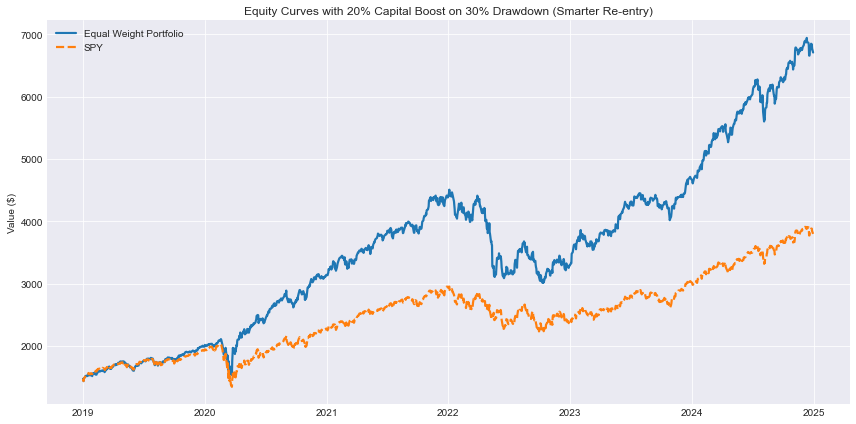

In [9]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(port_equity, linewidth=2.2, label="Equal Weight Portfolio")
plt.plot(spy_equity, linestyle="--", linewidth=2.2, label="SPY")
plt.title("Equity Curves with 20% Capital Boost on 30% Drawdown (Smarter Re-entry)")
plt.ylabel("Value ($)")
plt.legend()
plt.tight_layout()
plt.savefig("boosted_strategy_equity.png", dpi=150)
plt.show()

## Conclusion & Performance Recap

The **Drawdown-Triggered Capital Allocation Strategy** produced strong, risk-adjusted performance over a 6-year window (2019–2024), significantly outperforming the benchmark SPY ETF.

### Key Portfolio-Level Results:

| Metric                | Strategy Portfolio |  SPY Benchmark   |
|-----------------------|---------------------|-----------------|
| **Final Value**       | USD 6,710.76        | USD 3,798.51    |
| **CAGR**              | 29%                 | 17%             |
| **Sharpe Ratio**      | 1.32                | 0.90            |
| **Max Drawdown**      | 33%                 | 34%             |
| **Portfolio ROI**     | **4.57x**           | **2.58x**       |
| **T-value**           | **3.23**           | **2.20**       |
| **p-value**           | **0.0016**           | **0.03**       |

> ✅ The strategy **outperformed SPY by 1.7x** in ROI while maintaining a **lower maximum drawdown**, indicating better downside control.

---

### Insights by Stock:

- **Top Performer (Absolute Returns)**: `NVDA`, ROI = 9.26x, CAGR = 60%
- **Most Boosted**: `F` (12 boosts), but only marginal ROI (0.95x) – high volatility, low recovery
- **Best Risk-Adjusted Return**: `COST`, Sharpe = 1.28
- **Consistent Winners**: `GOOGL`, `WMT`, `COST`, `BLK` – all had strong CAGR, Sharpe > 0.75
- **Underperformers**: `JNJ`, despite no boosts, returned only 1.33x — lower volatility, defensive profile

---

### Strategic Takeaways:

- Stocks with **high upside volatility** and momentum (like `NVDA`, `COST`) benefited disproportionately from the capital re-entry logic.
- The **drawdown detection** + **re-entry boost** allows for better capital deployment into recoveries rather than blindly averaging down.
- **SPY underperformed**, both in absolute and risk-adjusted terms, showing that active drawdown-based allocation has merit over passive buy-and-hold in this sample.

---

### Final Thoughts:

This strategy is robust, interpretable, and grounded in realistic behavioral assumptions — exiting during deep falls and boosting capital only upon recovery. Its performance edge, especially when backtested across diversified sectors, suggests it could act as a valuable component in a multi-strategy portfolio or managed account structure.

It also demonstrates the ability to:

- **Dynamically manage risk** via drawdown exits  
- **Amplify winners** through systematic capital boosts  
- **Deliver alpha** without market timing or forecasting earnings